# INF552_HW4 
#### YEN-CHEN CHOU
#### ID: 2256319992
https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

# 1. The LASSO and Boosting for Regression

In [1]:
import numpy as np
import pandas as pd
import xgboost
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
# from fancyimpute import KNN
from sklearn import metrics

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# os.chdir("/Users/yc/Desktop/OneDrive/USC/課程syllabus+resource/INF552/2019_spring_syllabus/Homework/")

Using TensorFlow backend.


In [0]:
with open("col.txt", "r") as f:
    col_ls = [i.rstrip().split()[0] for i in f.readlines()]

In [3]:
df = pd.read_csv("communities.data.txt", header = None, names = col_ls)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(26)
memory usage: 1.9+ MB


In [0]:
df = df.replace({"?" : None})

In [0]:
train_df = df[:1495]
test_df = df[1495:]

### (b) The data set has missing values. Use a data imputation technique to deal with the missing values in the data set. The data description mentions some features are nonpredictive. Ignore those features.

In [7]:
train_df.isnull().sum().sort_values(ascending = False)

LemasSwFTFieldOps       1256
PctPolicAsian           1256
PolicBudgPerPop         1256
LemasSwornFT            1256
LemasSwFTPerPop         1256
LemasSwFTFieldPerPop    1256
LemasTotalReq           1256
LemasTotReqPerPop       1256
PolicReqPerOffic        1256
PolicPerPop             1256
PctPolicWhite           1256
PctPolicBlack           1256
PctPolicHisp            1256
RacialMatchCommPol      1256
PctPolicMinor           1256
PolicCars               1256
LemasGangUnitDeploy     1256
OfficAssgnDrugUnits     1256
PolicOperBudg           1256
LemasPctPolicOnPatr     1256
PolicAveOTWorked        1256
NumKindsDrugsSeiz       1256
community                880
county                   878
OtherPerCap                1
AsianPerCap                0
PctEmplProfServ            0
HispPerCap                 0
NumUnderPov                0
PctPopUnderPov             0
                        ... 
PopDens                    0
PctUsePubTrans             0
LemasPctOfficDrugUn        0
MedYrHousBuilt

In [8]:
test_df.isnull().sum().sort_values(ascending = False)

LemasSwFTFieldOps       419
PctPolicAsian           419
PolicBudgPerPop         419
LemasSwornFT            419
LemasSwFTPerPop         419
LemasSwFTFieldPerPop    419
LemasTotalReq           419
LemasTotReqPerPop       419
PolicReqPerOffic        419
PolicPerPop             419
PctPolicWhite           419
PctPolicBlack           419
PctPolicHisp            419
RacialMatchCommPol      419
PctPolicMinor           419
PolicCars               419
LemasGangUnitDeploy     419
OfficAssgnDrugUnits     419
PolicOperBudg           419
LemasPctPolicOnPatr     419
PolicAveOTWorked        419
NumKindsDrugsSeiz       419
community               297
county                  296
AsianPerCap               0
OtherPerCap               0
PctEmplProfServ           0
HispPerCap                0
NumUnderPov               0
PctPopUnderPov            0
                       ... 
PopDens                   0
PctUsePubTrans            0
LemasPctOfficDrugUn       0
MedYrHousBuilt            0
PctVacMore6Mos      

drop columns

In [0]:
train_df = train_df.drop(["LemasSwFTFieldOps", "PctPolicAsian", "PolicBudgPerPop",
                          "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldPerPop",
                          "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
                          "PolicPerPop", "PctPolicWhite", "PctPolicBlack",
                          "PctPolicHisp", "RacialMatchCommPol", "PctPolicMinor", 
                          "PolicCars", "LemasGangUnitDeploy", "OfficAssgnDrugUnits",
                          "PolicOperBudg", "LemasPctPolicOnPatr", "PolicAveOTWorked",
                          "NumKindsDrugsSeiz", "community", "county", 
                          "state", "communityname", "fold"], axis = 1)

In [0]:
test_df = test_df.drop(["LemasSwFTFieldOps", "PctPolicAsian", "PolicBudgPerPop",
                        "LemasSwornFT", "LemasSwFTPerPop", "LemasSwFTFieldPerPop",
                        "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic",
                        "PolicPerPop", "PctPolicWhite", "PctPolicBlack",
                        "PctPolicHisp", "RacialMatchCommPol", "PctPolicMinor", 
                        "PolicCars", "LemasGangUnitDeploy", "OfficAssgnDrugUnits",
                        "PolicOperBudg", "LemasPctPolicOnPatr", "PolicAveOTWorked",
                        "NumKindsDrugsSeiz", "community", "county", 
                        "state", "communityname", "fold"], axis = 1)

impute missing value

In [0]:
train_df = train_df.fillna(value = df["OtherPerCap"].astype("float").mean())

In [0]:
train_df["OtherPerCap"] = train_df["OtherPerCap"].astype("float")
test_df["OtherPerCap"] = test_df["OtherPerCap"].astype("float")

### (c) Plot a correlation matrix for the features in the data set.

In [0]:
corr = train_df.corr()

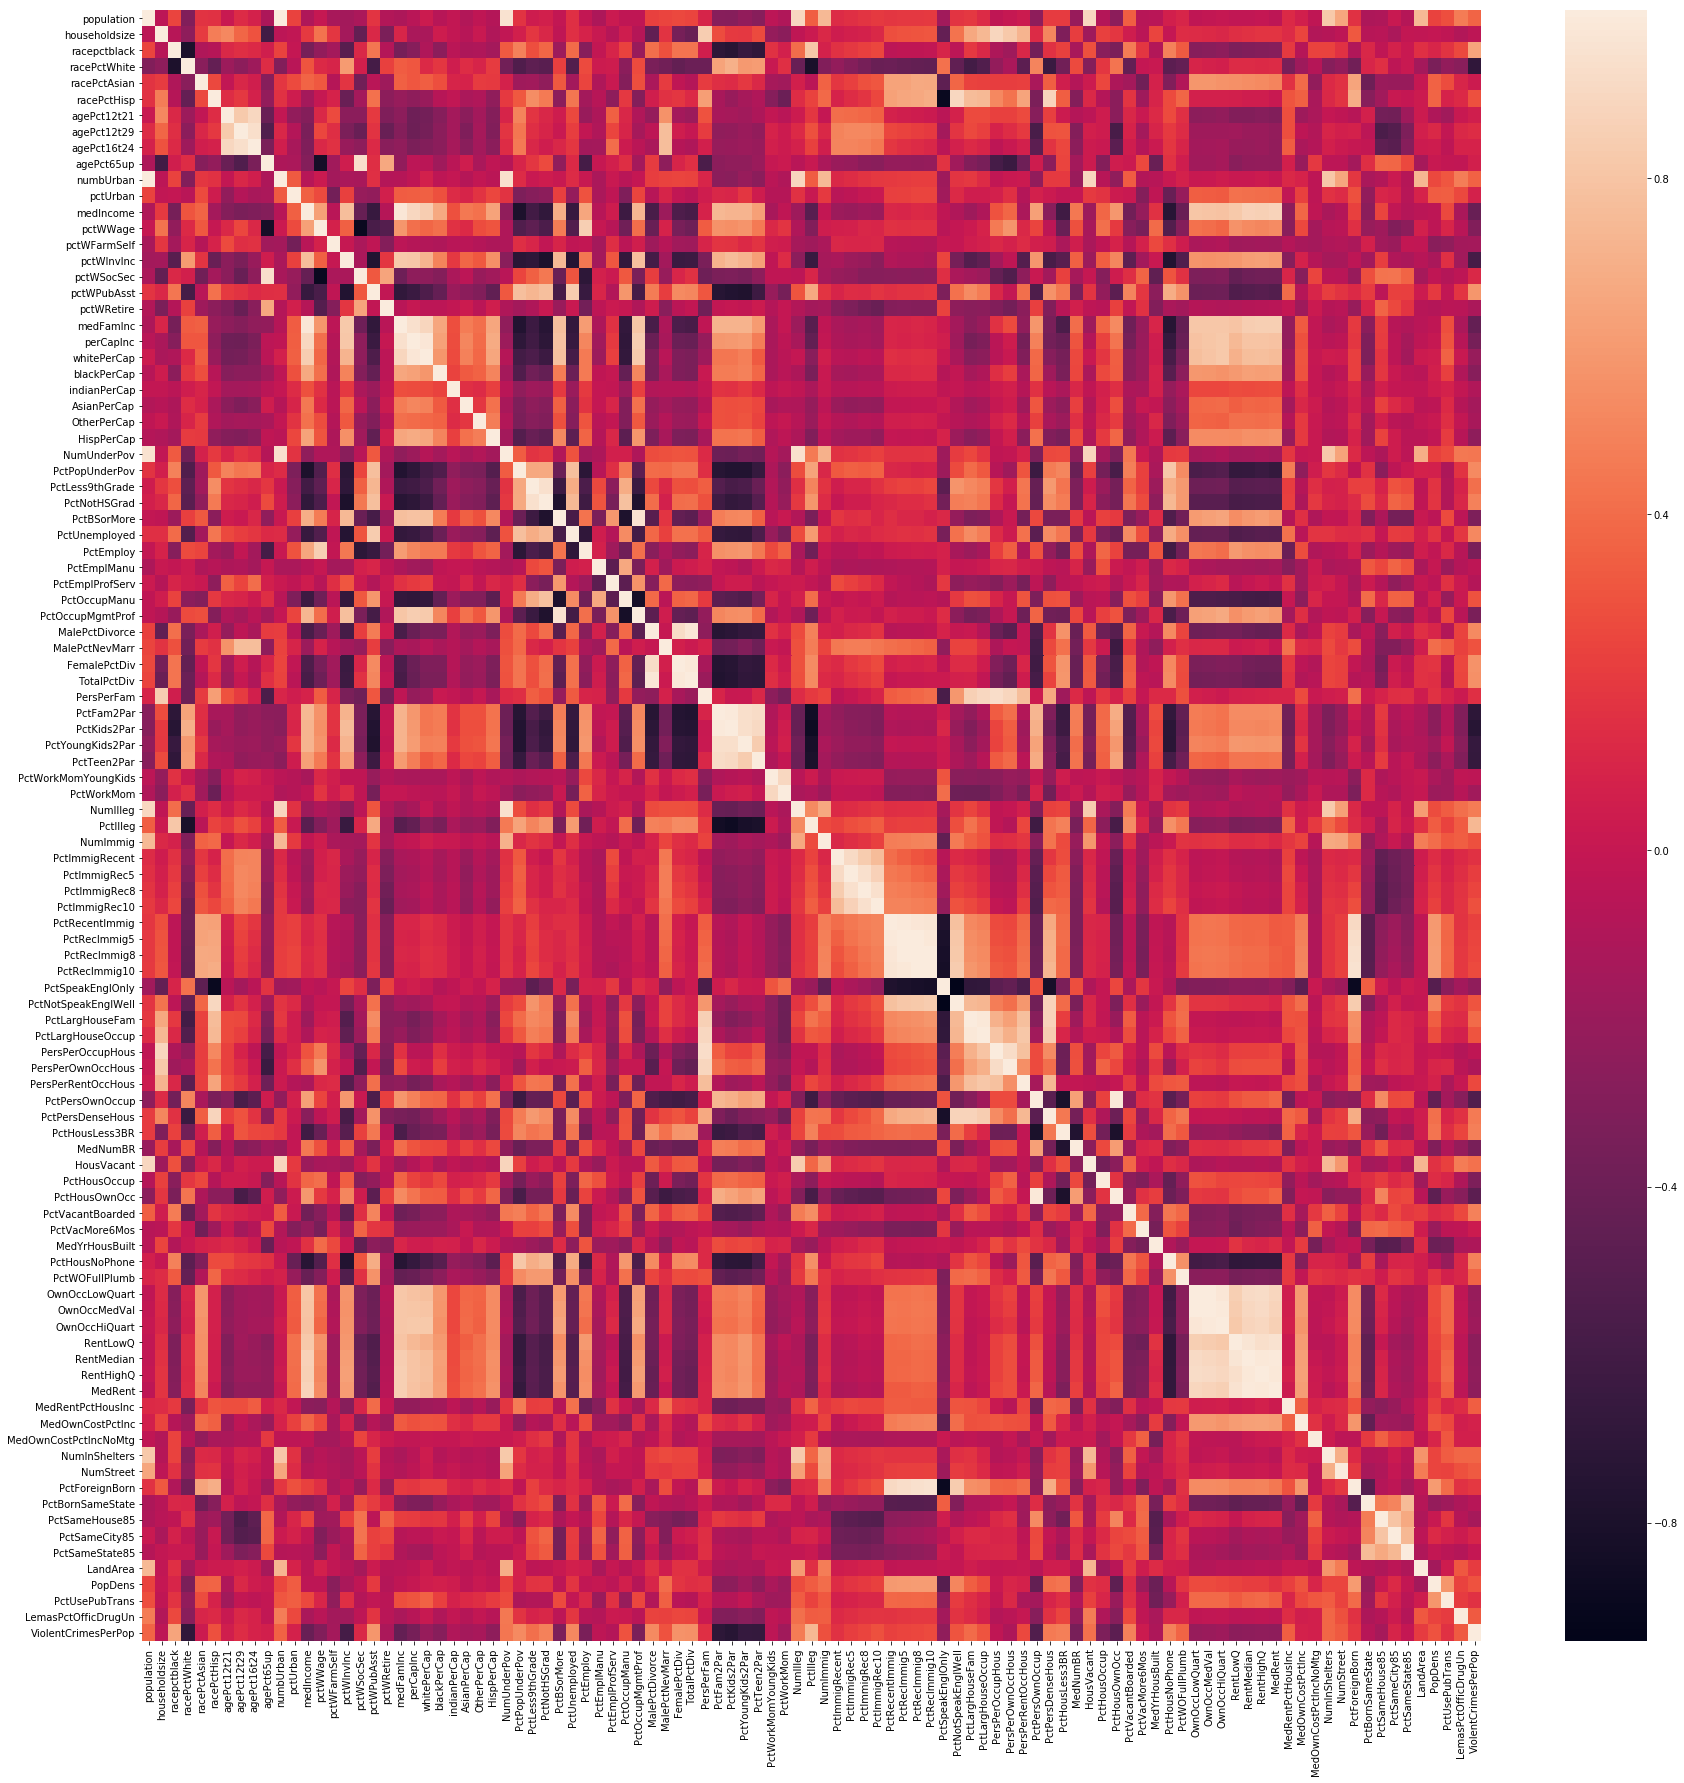

In [14]:
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(corr, annot = False)

### (d) Calculate the Coeifcient of Variation CV for each feature, where CV = s / m, in which s is sample variance and m is sample mean..

In [15]:
feature_cv = train_df.std() / train_df.mean()
feature_cv[:10]

population       2.241105
householdsize    0.355800
racepctblack     1.428885
racePctWhite     0.330213
racePctAsian     1.359100
racePctHisp      1.612091
agePct12t21      0.369083
agePct12t29      0.291315
agePct16t24      0.500310
agePct65up       0.412776
dtype: float64

### (e) Pick 128**0.5 features with highest CV , and make scatter plots and box plots forthem. Can you draw conclusions about significance of those features, just by thescatter plots?

The significance of all the features to the label seems week but still have little positive relationship. As for the relationship between features are stronger.

In [0]:
scatter_e_df = feature_cv.sort_values(ascending = False)[:round(128**0.5)]

In [17]:
scatter_e_df

NumStreet              4.292923
NumInShelters          3.470952
NumIlleg               3.058964
NumImmig               2.926635
LemasPctOfficDrugUn    2.552946
NumUnderPov            2.342443
population             2.241105
numbUrban              2.038461
HousVacant             1.968467
LandArea               1.645408
racePctHisp            1.612091
dtype: float64

In [0]:
scatter_plot = list(scatter_e_df.index)
scatter_plot.append("ViolentCrimesPerPop")

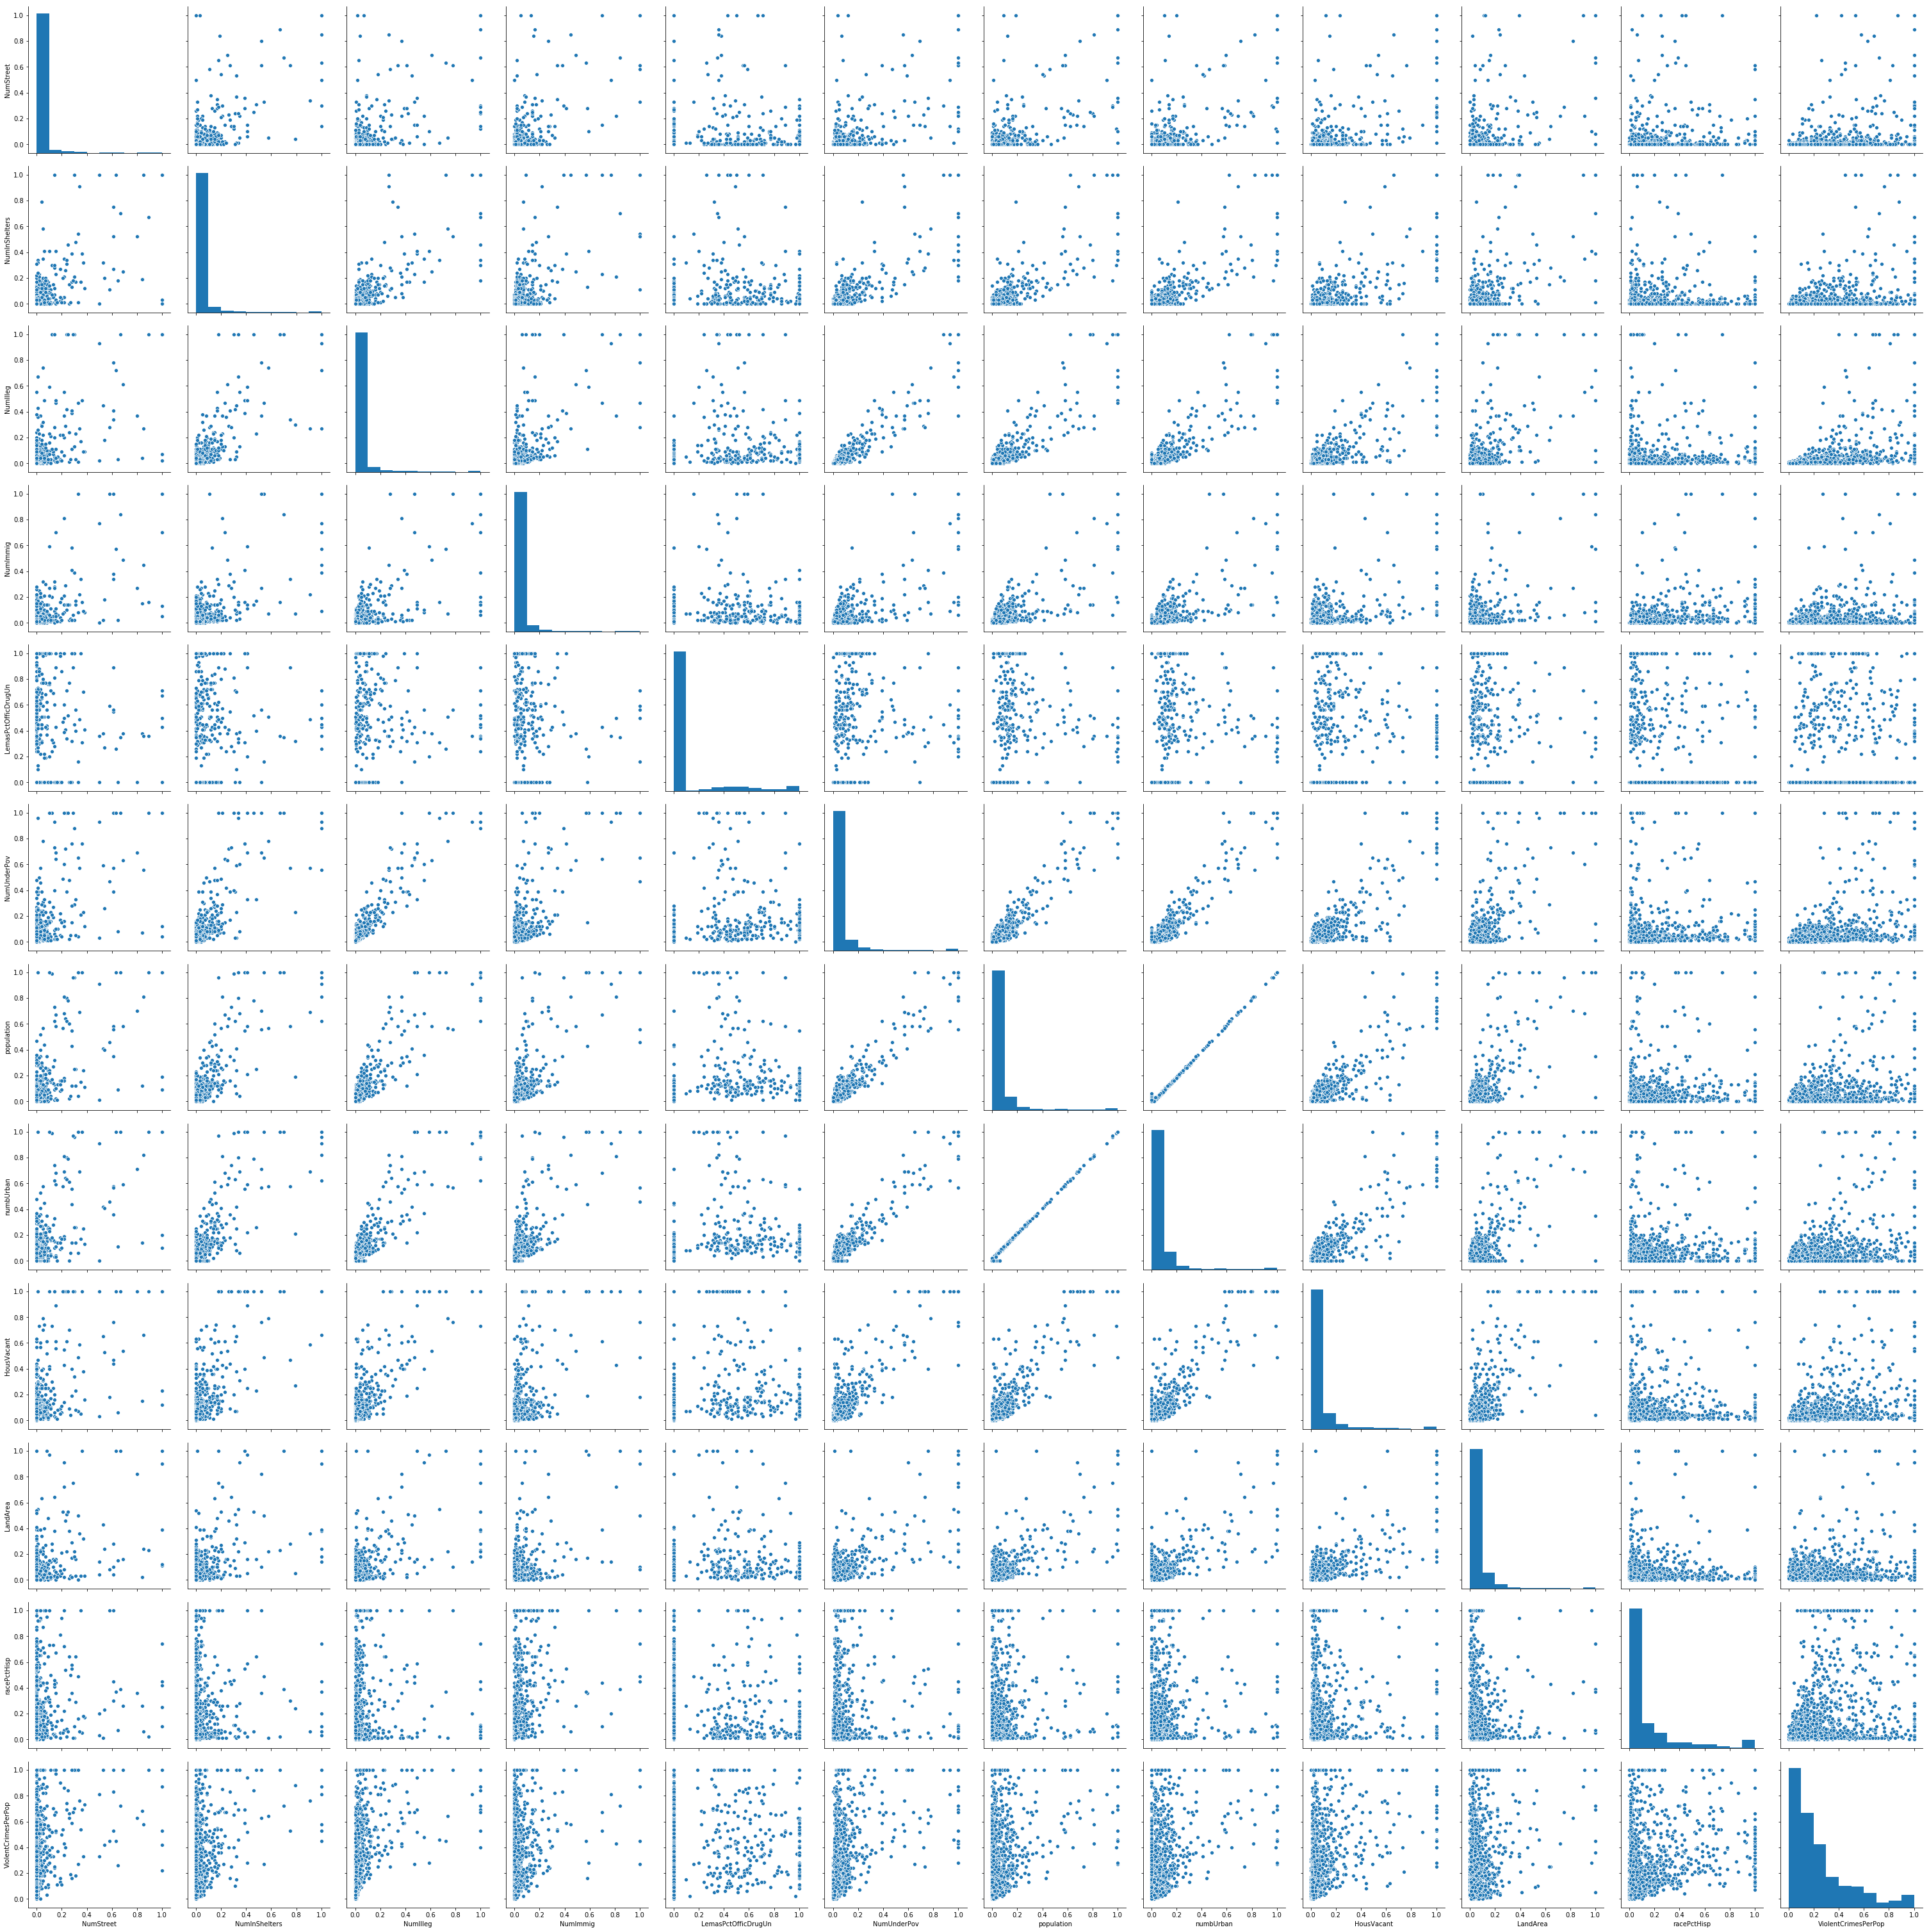

In [19]:
sns.pairplot(train_df[scatter_plot], height = 3.5)
plt.show()

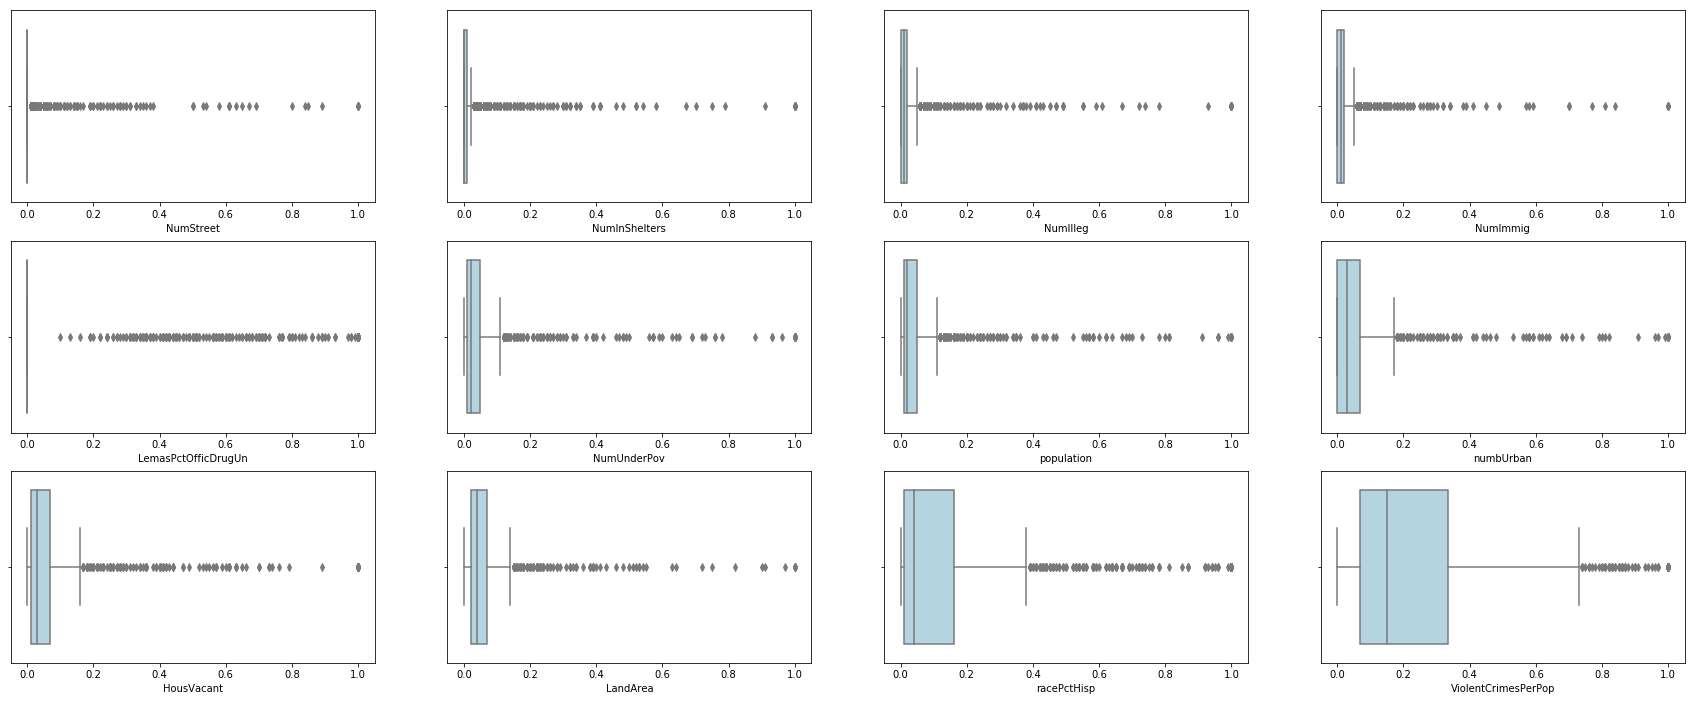

In [20]:
# box plot
fig, ax = plt.subplots(3,4, figsize=(30, 12))
box = list(scatter_e_df.index)
count = 0
for i in range(3):
    for j in range(4):
        sns.boxplot(train_df[scatter_plot[count]], ax = ax[i][j], color = "lightblue")
        count += 1
plt.show()
print("\n\n\n\n")

### (f) Fit a linear model using least squares to the training set and report the test error.

In [0]:
# split the label and features
X_train = train_df.iloc[:,:-1]
X_test = test_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
y_test = test_df.iloc[:,-1]

#### mean square error:0.0178

In [22]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
mse = np.mean((y_test - y_pred)**2, axis = 0)
print("mean square error:{:.4f}".format(mse))

mean square error:0.0178


### (g) Fit a ridge regression model on the training set, with  chosen by cross-validation. Report the test error obtained.

#### {'alpha': 1}
#### mean square error:0.0175

In [23]:
parameters = {"alpha" : [0,0.1,1,5,10,100,1000]}
ridge_reg = Ridge()
clf = GridSearchCV(ridge_reg, parameters, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_params_)

ridge_reg = Ridge(alpha = clf.best_params_["alpha"])
ridge_reg.fit(X_train, y_train)
pred = ridge_reg.predict(X_test)
ridge_mse = np.mean((y_test - pred)**2, axis = 0)
print("mean square error:{:.4f}".format(ridge_mse))

{'alpha': 1}
mean square error:0.0175


### (h) Fit a LASSO model on the training set, with lambda chosen by cross-validation. (?)

In [24]:
lasso = Lasso()
parameters = {"alpha" : [0,0.1,1,5,10,100,1000]}
clf = GridSearchCV(lasso, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print("best parameter: {}".format(clf.best_params_))
print ("Best score: {:.3f}".format(clf.best_score_))

Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
best parameter: {'alpha': 0}
Best score: 0.652


#### test error: 0.018

In [25]:
# model and test error
lasso = Lasso(alpha = clf.best_params_["alpha"])
lasso.fit(train_df, y_train)
ypred = ridge_reg.predict(X_test)
lasso_mse = np.mean((y_test - ypred)**2, axis = 0)
print("test error:{:.3f}\n".format(lasso_mse))

# get selected variables
for k,v in sorted(zip(map(lambda x: round(x, 3), lasso.coef_), \
                  X_train.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    if abs(k) > 0:
        print(v + ": " + str(k)) 

test error:0.018

PersPerFam: -0.005
PersPerOccupHous: 0.005
MedRent: 0.004
agePct16t24: -0.004
OwnOccMedVal: 0.003
PctFam2Par: 0.003
PctHousOwnOcc: 0.003
PctLargHouseOccup: -0.003
PctPersOwnOccup: -0.003
RentHighQ: -0.003
RentMedian: -0.003
TotalPctDiv: -0.003
FemalePctDiv: 0.002
MalePctDivorce: 0.002
PctForeignBorn: 0.002
PctKids2Par: -0.002
PctLargHouseFam: 0.002
PctRecImmig5: -0.002
PersPerRentOccHous: -0.002
agePct12t21: 0.002
agePct12t29: 0.002
medIncome: -0.002
numbUrban: -0.002
pctWSocSec: 0.002
perCapInc: 0.002
population: 0.002
whitePerCap: -0.002
MalePctNevMarr: 0.001
OwnOccLowQuart: -0.001
PctBSorMore: -0.001
PctLess9thGrade: 0.001
PctNotSpeakEnglWell: -0.001
PctOccupMgmtProf: 0.001
PctPopUnderPov: 0.001
PctRecentImmig: 0.001
PctSpeakEnglOnly: 0.001
PctWorkMom: 0.001
PersPerOwnOccHous: 0.001
RentLowQ: 0.001
agePct65up: -0.001
householdsize: -0.001
medFamInc: 0.001
pctWPubAsst: 0.001
pctWWage: 0.001
racePctHisp: 0.001


### (i) Fit a PCR model on the training set, with M (the number of principal components) chosen by cross-validation. Report the test error obtained.
#### test error form best number of M = 85 component. Test error: 0.018033569680577285

In [26]:
best_score, best_num_comp = 0, 1
for n_comp in range(1, len(X_train.columns)+1):
    
    # PCA
    pca = PCA(n_components = n_comp)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test) 
    # LR
    lm = LinearRegression()
    # cross validation
    kf = KFold(n_splits = 5, shuffle = True)
    score = np.mean(cross_val_score(lm, reduced_X_train, y_train, cv = kf))
    # compare performace
    if best_score < score:
        best_score = score
        best_num_comp = n_comp
    
# final model
pca = PCA(n_components = best_num_comp)
reduced_X_train = pca.fit_transform(X_train)
reduced_X_test = pca.transform(X_test)

lm.fit(reduced_X_train, y_train)
y_pred = lm.predict(reduced_X_test)
mse = np.mean((y_test - y_pred)**2, axis = 0)
print("test error form best number of {} component: {}".format(best_num_comp, mse))

test error form best number of 84 component: 0.018091666933717342


### (j) In this section, we would like to fit a boosting tree to the data. 
#### best alpha: 0

In [27]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)
# specify parameters via map
best_error, best_alpha = 0, 0
gamma_ls = [0, 0.1, 0.5, 1, 10, 100]
for i in gamma_ls:
    param = {"gamma":i}
    bst = xgb.train(param, dtrain)
    # make prediction
    preds = bst.predict(dtest)
    mse = np.mean((y_test - preds)**2, axis = 0)
    if best_error > mse:
        best_error = mse
        best_alpha = i
print("best alpha: {}".format(best_alpha))

best alpha: 0


# 2. Tree-Based Methods

### (b) Data Preparation
#### i. Research what types of techniques are usually used for dealing with data with missing values.5 Pick at least one of them and apply it to this data in the next steps.6

In [70]:
df_train = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)
df_test = pd.read_csv("aps_failure_test_set.csv", skiprows = 20)
df_train = df_train.replace({"na" : np.NaN, "neg": 0, "pos" : 1})
df_test = df_test.replace({"na" : np.NaN,  "neg": 0, "pos" : 1})
print(df_train.shape)
print(df_test.shape)

(60000, 171)
(16000, 171)


In [71]:
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,NaN,NaN,NaN,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,NaN,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,NaN,NaN,NaN,NaN,NaN,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,NaN,NaN,NaN,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,NaN,0,3646660,NaN,6160,796,164860,350066,272956,1837600,301242,9148,22,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,NaN,NaN,NaN,NaN,NaN,NaN,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,NaN,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10580,12.69,21614,21614,

In [72]:
df_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,0,13124,2,1956,434,76,174,190,6198,1148,2948,2,0,8762,2566,480,380,196,516,86,66,74,0,124340,4,6,4,0,3976,318,107662,3458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110980,59.53,124340,124340,184970,54,686,12246,123880,13196,1209600,598,0,6,0,5913.6,0,5851.2,6,30,0,2,5512,4674,1388,1508,38,4,0,0,8,12,124340,0,1550,14,36,26,920,430,7650,2294,206,0,22,42,5336,1276,0,0,0,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,0,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,692,16286,0,280,44,50,1274,866,3362,11102,0,0,0,12564,1756,638,276,172,132,812,308,192,128,46894,4,2,38,0,5244,360,20520,3134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23320,81.89,46894,46894,48324,68,0,4486,46480,17050,1209600,726,2,4,0,7224.96,0,7768.32,0,42,0,0,4,7064,6200,2452,1246,12,0,0,14,54,46894,0,2202,28,114,350,700,1708,9622,2174,80,0,80,206,7802,1466,0,0,0,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,0,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,2808472,474782,0,22984,894,1162,1304,1856,388700,3424812,123828,23260,0,1662580,667960,387998,226078,161558,148288,154908,220820,147744,210866,4644422,958,7848,3624,0,1891670,47066,692800,265492,336240,194360,245240,NaN,NaN,NaN,NaN,NaN,175480,66002.89,4644422,4644422,4608738,22706,2272,95510,1006260,3991552,1209600,126310,0,104,0,3594885.12,0,374649.6,148,720,0,5154,174956,622312,1002504,793938,541734,345896,300806,201500,52,92,4644422,0,24818,964,162660,215004,217930,3038612,322718,6080,14,0,226,572,3593728,1911060,0,284,0,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,0,59816,NaN,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,2930694,2012,0,3526,904,1426,223226,2663348,1137664,104,0,0,0,1283806,928212,345132,265930,194770,158262,219942,620264,13880,0,4201350,98,238,880,16,1772828,51468,331744,316130,176000,208420,159380,NaN,NaN,NaN,NaN,NaN,100120,59816.46,4201350,4201350,4203050,29967.0,26214,51894,562680,4030198,1209600,114684,0,144,0,3387773.76,38633.28,599624.64,0,0,0,0,14308,475410,1109740,1528024,837114,58942,6220,440,1278,1292,4201350,NaN,6846,810,70090,345884,191284,2454600,926846,33558,280,0,1516,1398,2050280,64066,0,674,0,46,3413978

draw the pattern of the missing values

In [73]:
df_train.isnull().sum().sort_values(ascending = False)[:10]

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
cr_000    46329
ab_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
dtype: int64

In [74]:
df_test.isnull().sum().sort_values(ascending = False)[:10]

br_000    13129
bq_000    12981
bp_000    12721
bo_000    12376
cr_000    12363
ab_000    12363
bn_000    11713
bm_000    10546
bl_000     7226
bk_000     6094
dtype: int64

In [33]:
df_train = df_train.astype("float")
df_test = df_test.astype("float")
df_train_col = df_train.columns
df_test_col = df_test.columns
df_train = SoftImpute().fit_transform(df_train)
df_test = SoftImpute().fit_transform(df_test)

# df_train.fillna(df_train.mean(), inplace = True)
# df_test.fillna(df_test.mean(), inplace = True)

[SoftImpute] Max Singular Value of X_init = 207329831370.562317
[SoftImpute] Iter 1: observed MAE=387812.332782 rank=5
[SoftImpute] Iter 2: observed MAE=384440.249240 rank=5
[SoftImpute] Iter 3: observed MAE=384007.337817 rank=5
[SoftImpute] Iter 4: observed MAE=384215.446633 rank=5
[SoftImpute] Iter 5: observed MAE=384546.551647 rank=5
[SoftImpute] Iter 6: observed MAE=384850.331706 rank=5
[SoftImpute] Iter 7: observed MAE=385097.793081 rank=5
[SoftImpute] Iter 8: observed MAE=385290.201243 rank=5
[SoftImpute] Iter 9: observed MAE=385436.048330 rank=5
[SoftImpute] Iter 10: observed MAE=385545.760991 rank=5
[SoftImpute] Iter 11: observed MAE=385628.253061 rank=5
[SoftImpute] Iter 12: observed MAE=385690.667791 rank=5
[SoftImpute] Iter 13: observed MAE=385738.205506 rank=5
[SoftImpute] Iter 14: observed MAE=385774.698181 rank=5
[SoftImpute] Iter 15: observed MAE=385803.066284 rank=5
[SoftImpute] Iter 16: observed MAE=385825.335004 rank=5
[SoftImpute] Iter 17: observed MAE=385843.020246 

In [0]:
df_train = pd.DataFrame(df_train, columns = df_train_col)
df_test = pd.DataFrame(df_test, columns = df_test_col)

#### ii. For each of the 170 features, calculate the coecient of variation CV = s/m, where s is sample variance and m is sample mean.

In [37]:
feature_cv_2 = df_train.std() / df_train.mean()
feature_cv_2[:5]

class       7.681210
aa_000      2.450938
ab_000      6.427257
ac_000      2.307516
ad_000    243.376731
dtype: float64

#### iii. Plot a correlation matrix for your features using pandas or any other tool.

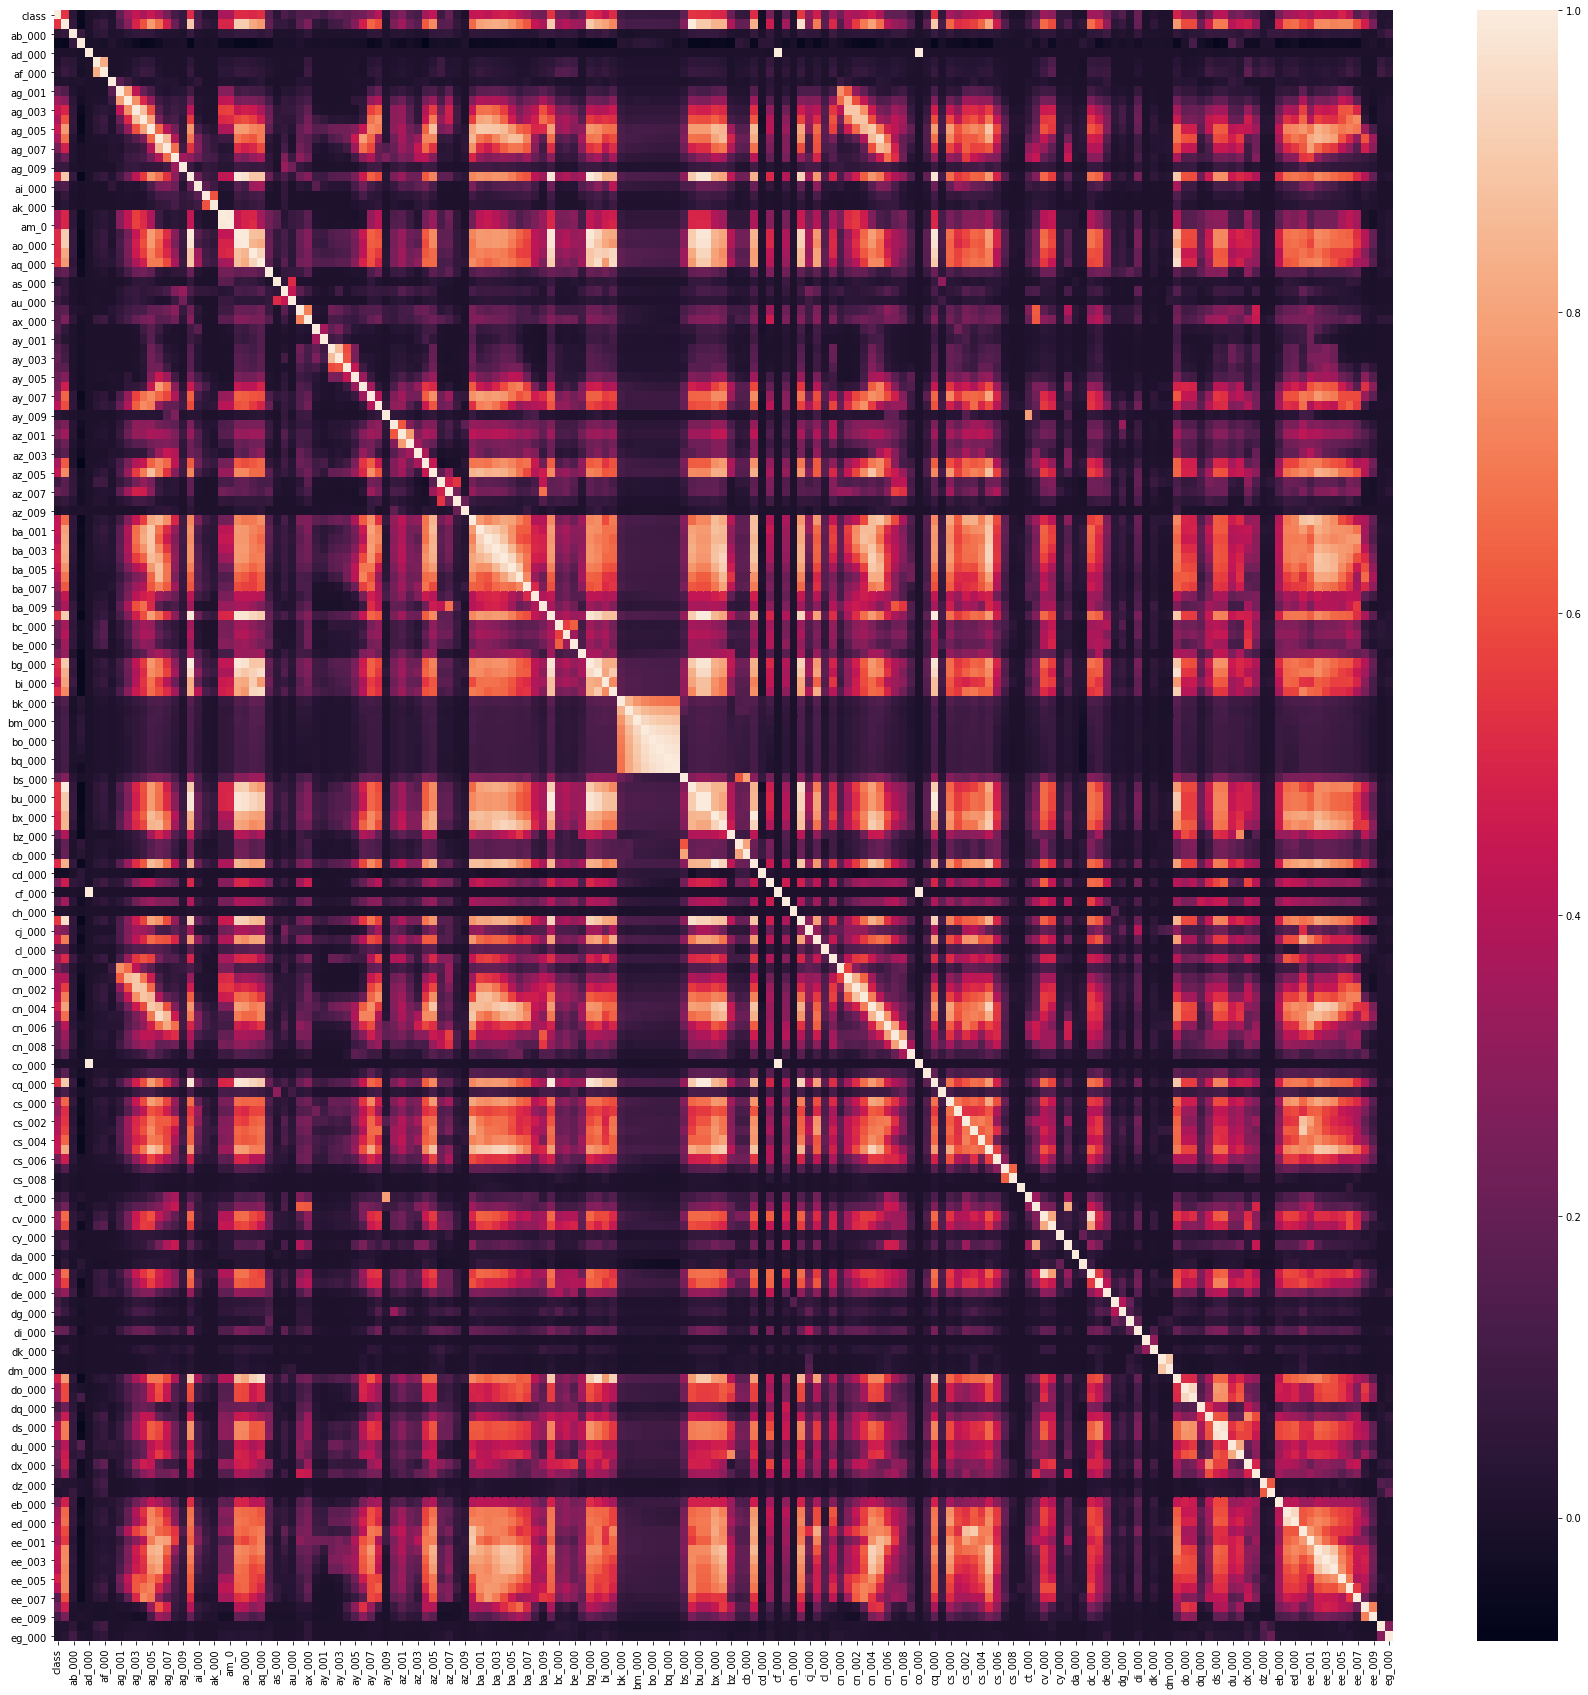

In [38]:
corr_plot = df_train.corr()
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(corr_plot, annot = False)

#### iv. Pick 170**0.5 features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR.

au_000 and as_000 have more positive relationships on positive label. As for others, they are all hard to draw any conclusions

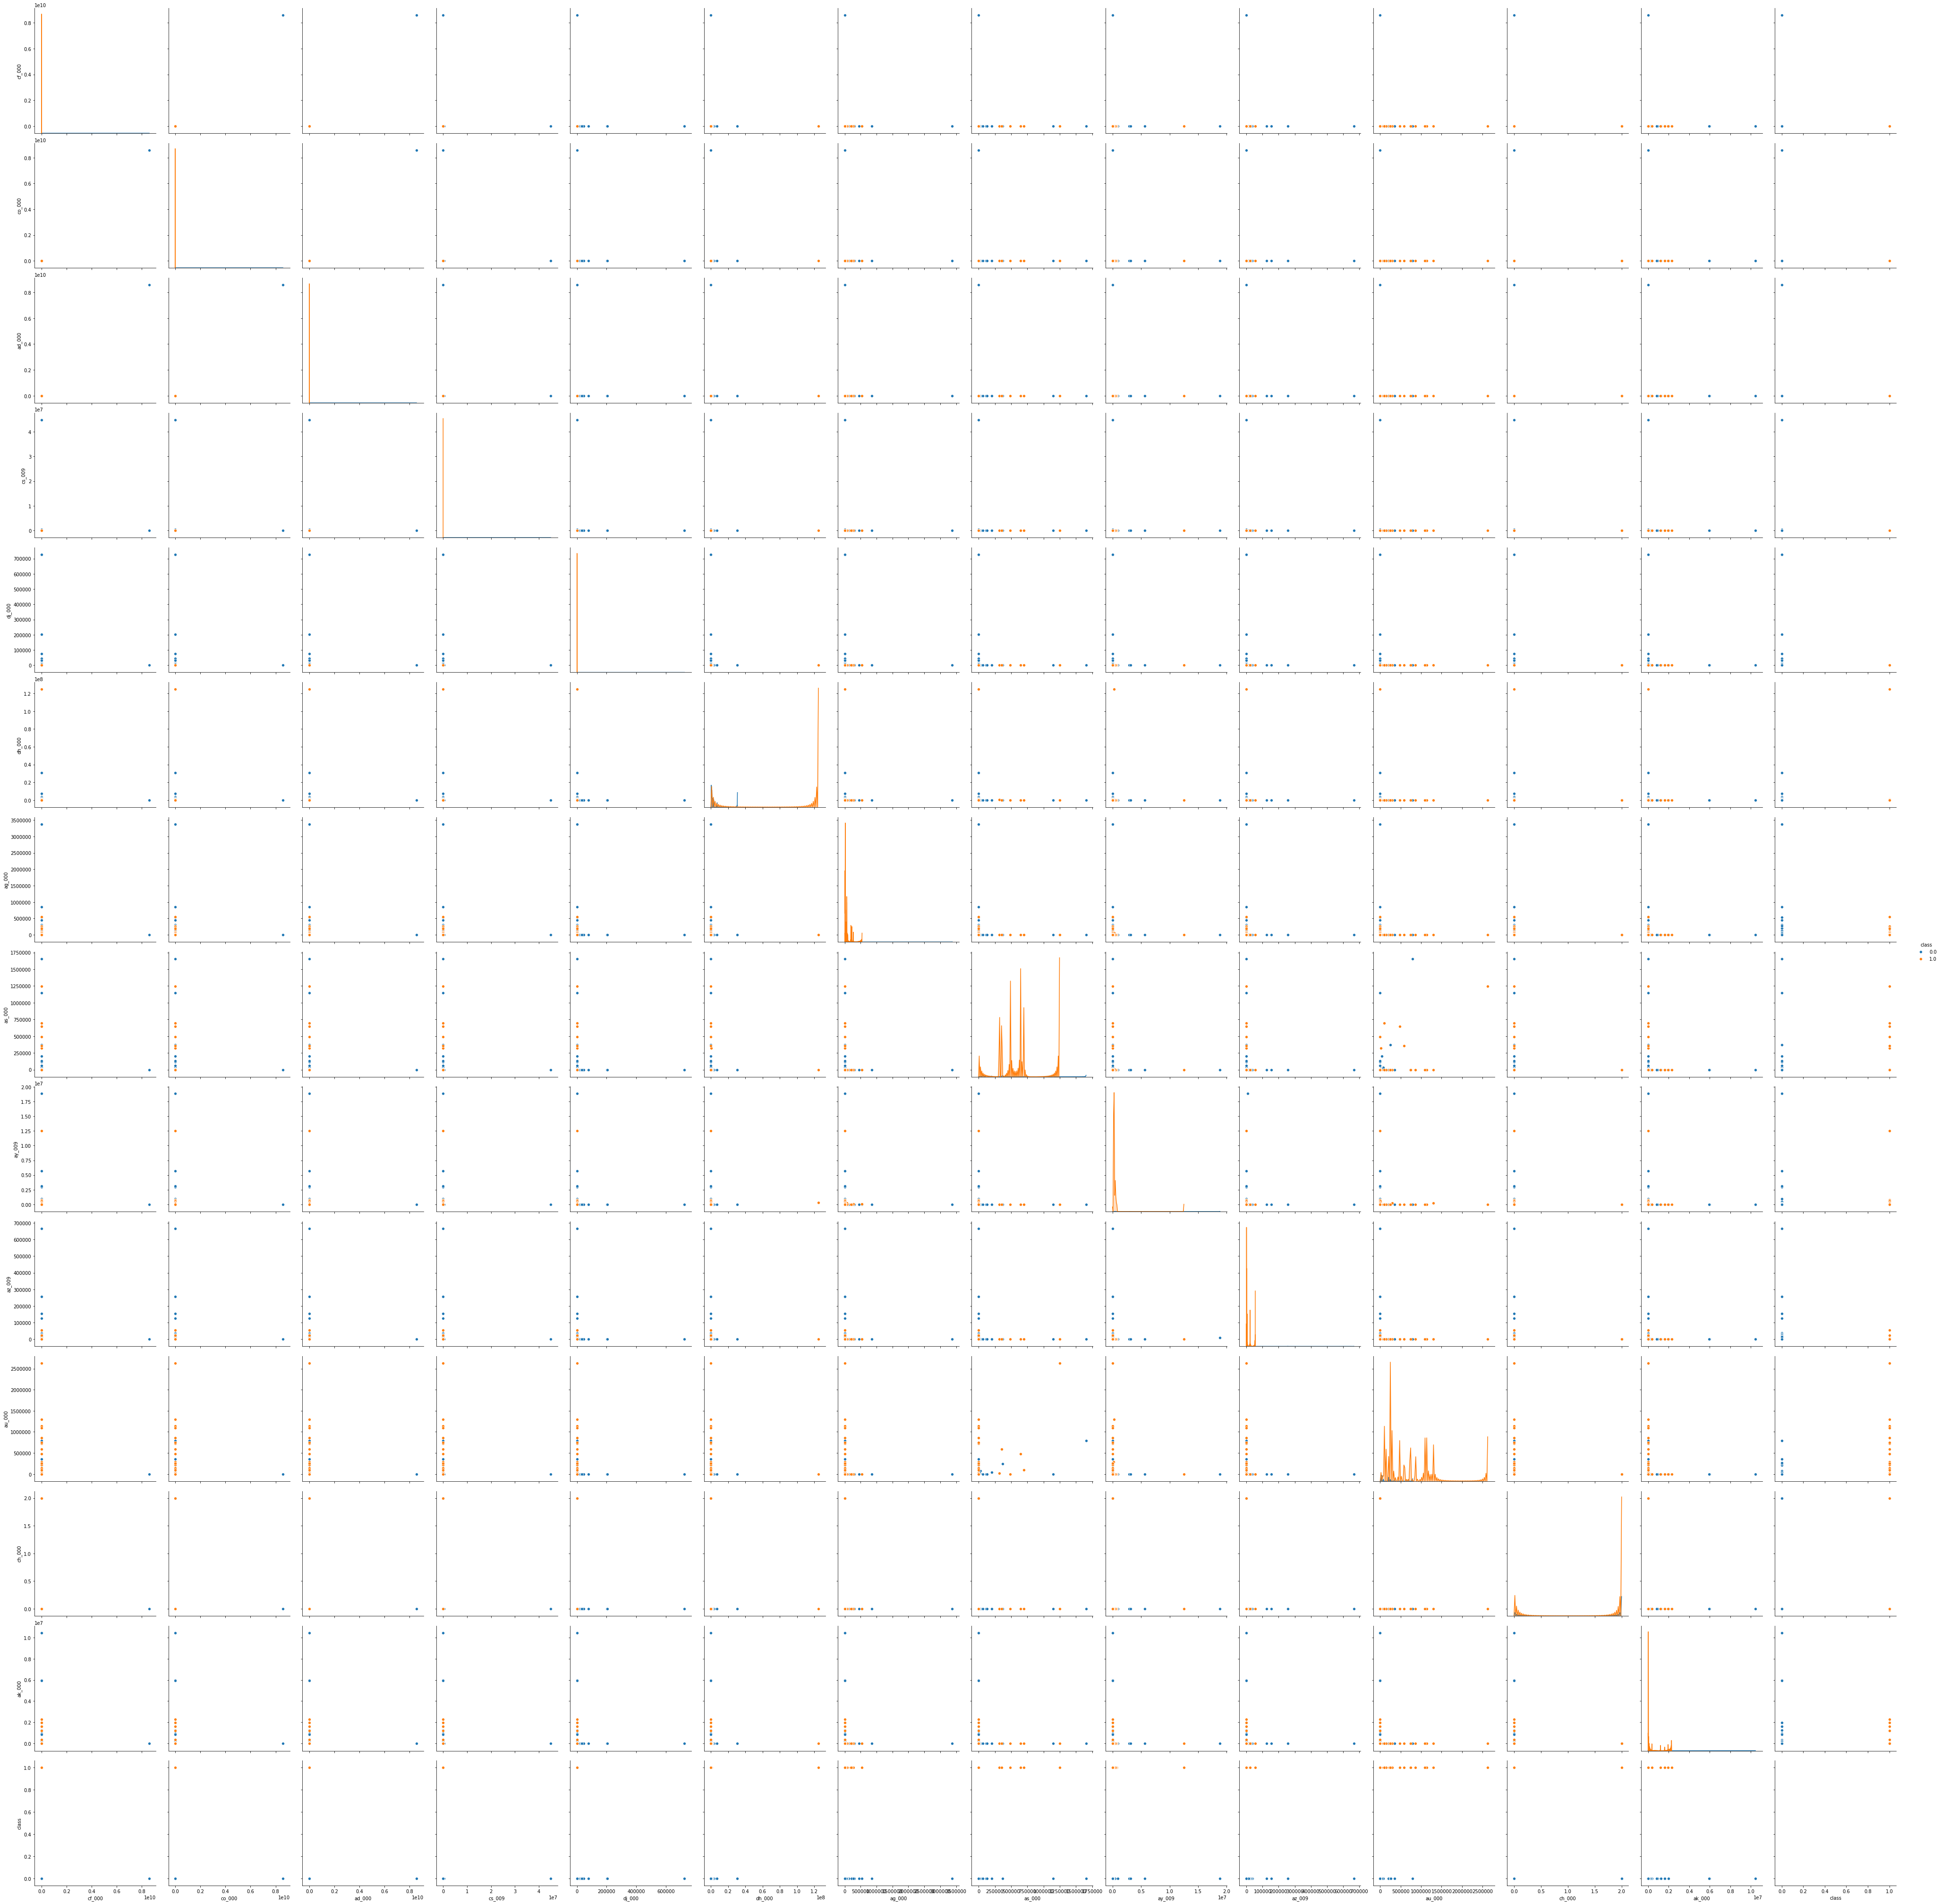

In [39]:
scatter_e_df2 = feature_cv_2.sort_values(ascending = False)[:round(170**0.5)]
scatter_plot2 = list(scatter_e_df2.index)
scatter_plot2.append("class")
sns.pairplot(df_train[scatter_plot2], hue = "class", height = 4)
plt.show()

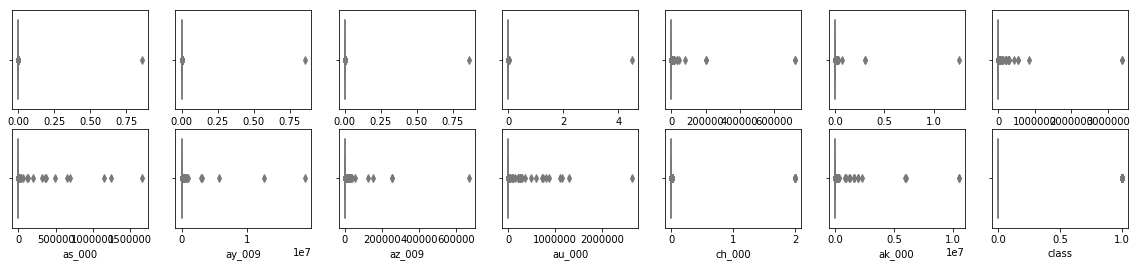

In [40]:
# box plot
fig, ax = plt.subplots(2,7, figsize=(20, 4))
box = list(scatter_e_df2.index)
count = 0
for i in range(2):
    for j in range(7):
        sns.boxplot(df_train[scatter_plot2[count]], ax = ax[i][j], color = "lightblue")
        count += 1
plt.show()
print("\n\n\n\n")

#### v. Determine the number of positive and negative data. Is this data set imbalanced?

Yes

In [41]:
print(df_train["class"].value_counts() / len(df_train["class"]) * 100)
print(df_test["class"].value_counts() / len(df_test["class"]) * 100)

0.0    98.333333
1.0     1.666667
Name: class, dtype: float64
0.0    97.65625
1.0     2.34375
Name: class, dtype: float64


### (c) Train a random forest to classify the data set. Calculate the confusion matrix, ROC, AUC, and misclassiﬁcation for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [0]:
def draw_ROC_confusion(model, X_test, y_test, name, p_val = False):

    y_prob = model.predict_proba(X_test)[:, 1]
    fpos_rate, tpos_rate, _ = roc_curve(y_test, y_prob)
    y_pred = model.predict(X_test)
    
    # OOB error
    print("OOB error", 1 - model.oob_score_)
    
    # p-value & parameters
    if p_val == False:
        pass
    else:
        print(" 1.column names: {} \n\n 2.coefficient: {}\n\n 3.p-value:{}".format(X_test.columns, model.coef_, p_val))
    
    # confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    test_error = (conf_matrix[0][1] + conf_matrix[1][0]) / len(y_pred)
    print("test error", test_error)
    print("\n confusion matrix: \n", conf_matrix)

    # ROC curve plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot([0, 1], [0, 1], "--")
    ax.plot(fpos_rate, tpos_rate, lw = 2.5, c = "orange", linestyle = "dashed")
    ax.legend(["Random Guess", "{} curve".format(name)], loc = "best")
    ax.set_xlabel("False positive rate", fontsize = 20)
    ax.set_ylabel("True positive rate", fontsize = 20)
    ax.set_title("ROC curve - {} model".format(name), fontsize = 20)
    plt.show()
    print("AUC: {} \n\n".format(metrics.auc(fpos_rate, tpos_rate))) 

In [0]:
# split the label and features
X_train = df_train.iloc[:,1:]
X_test = df_test.iloc[:,1:]
y_train = df_train.iloc[:,0]
y_test = df_test.iloc[:,0]

OOB error 0.008483333333333287
test error 0.0095

 confusion matrix: 
 [[15599    26]
 [  126   249]]


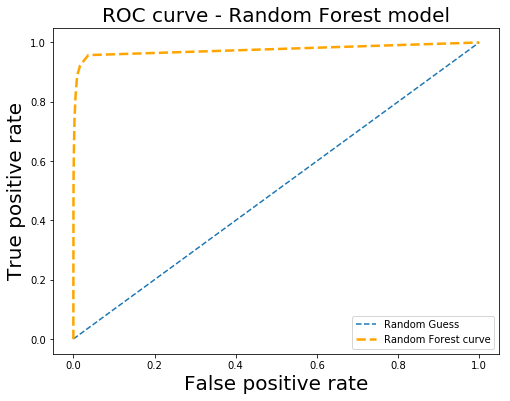

AUC: 0.9752946346666667 




In [68]:
rf = RandomForestClassifier(bootstrap = True, oob_score = True)
rf.fit(X_train, y_train)
draw_ROC_confusion(rf, X_test, y_test, p_val = False, name = "Random Forest")

### (d) Research how class imbalance is addressed in random forests. Compensate the imbalance

OOB error 0.00615254237288132
test error 0.011875

 confusion matrix: 
 [[15589    36]
 [  154   221]]


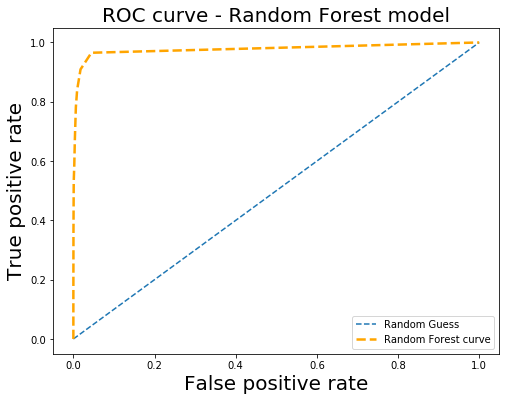

AUC: 0.9777683626666667 




In [69]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
rf2 = RandomForestClassifier(bootstrap = True, oob_score = True)
rf2.fit(X_resampled, y_resampled)
draw_ROC_confusion(rf2, X_test, y_test, p_val = False, name = "Random Forest")

### (e) Model Trees

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.

test error 0.0243125

 confusion matrix: 
 [[15264   361]
 [   28   347]]


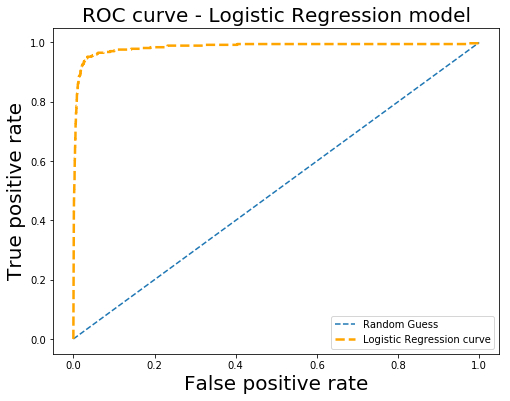

AUC: 0.984431104 




In [0]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
lr = LogisticRegression()
lr.fit(X_res, y_res)
draw_ROC_confusion(lr, X_test, y_test, p_val = False, name = "Logistic Regression")

# 3. ISLR 6.8.3
<a href="https://ibb.co/QpCB52g"><img src="https://i.ibb.co/8Nd3hWC/2019-02-27-2-16-02.png" alt="2019-02-27-2-16-02" border="0"></a>

#### (a) (iv)

#### (b) (ii)

#### (c) (iii)

#### (d) (iv)

#### (e) (v)

# 4. ISLR 6.8.5
<a href="https://ibb.co/THbhvbc"><img src="https://i.ibb.co/LCJpkJS/2019-02-27-2-16-17.png" alt="2019-02-27-2-16-17" border="0"></a>

<a href="https://ibb.co/vsynmKh"><img src="https://i.ibb.co/k3bC0WJ/2019-03-05-3-08-57.png" alt="2019-03-05-3-08-57" border="0"></a>

<a href="https://ibb.co/GcKJ5G6"><img src="https://i.ibb.co/yWwRQK9/2019-03-05-3-09-01.png" alt="2019-03-05-3-09-01" border="0"></a><br /><a target='_blank' href='https://babynamesetc.com/y'></a><br />

<a href="https://ibb.co/XDHCwWL"><img src="https://i.ibb.co/zFd4kmx/2019-03-05-3-09-07.png" alt="2019-03-05-3-09-07" border="0"></a>

# 5. ISLR 8.4.5
<a href="https://ibb.co/sPskVvg"><img src="https://i.ibb.co/X4FNCZW/2019-02-27-2-17-20.png" alt="2019-02-27-2-17-20" border="0"></a><br /><a target='_blank' href='https://aluminumsulfate.net/ammonium-sulfate'></a><br />
<a href="https://ibb.co/LgtKDd1"><img src="https://i.ibb.co/xgjZKq6/2019-02-27-2-17-26.png" alt="2019-02-27-2-17-26" border="0"></a>

In [0]:
import numpy as np

# majority, by default we classify into red when P(class is red | X)
p = [0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]
c = 0
for num in p:
  if num > 0.5:
    c += 1
print("majority: ", True if c > len(p)/22 else False)
  
# mean
print("mean: ", True if np.mean(p) > 0.5 else False)

majority:  True
mean:  False


# 6. ISLR 9.7.3
<a href="https://ibb.co/C247mfT"><img src="https://i.ibb.co/M6KVZm3/2019-02-27-2-17-57.png" alt="2019-02-27-2-17-57" border="0"></a>
<a href="https://ibb.co/jGGL17H"><img src="https://i.ibb.co/WFFcYSs/2019-02-27-2-18-05.png" alt="2019-02-27-2-18-05" border="0"></a><br /><a target='_blank' href='https://aluminumsulfate.net/uses-of-aluminum-sulfate'></a><br />

#### (a)

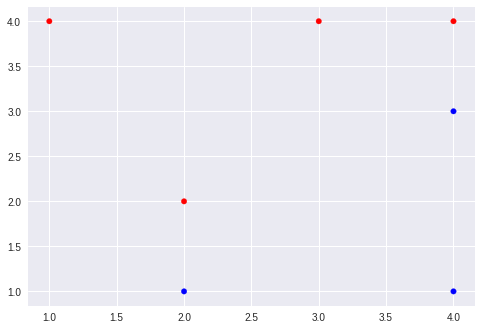

In [0]:
import pandas as pd
data = {"X1":[3,2,4,1,2,4,4],
        "X2":[4,2,4,4,1,3,1],
        "Y":["Red","Red","Red","Red","Blue","Blue","Blue"],
        "index":[1,2,3,4,5,6,7]}
df_islr = pd.DataFrame.from_dict(data)
df_islr = df_islr.set_index("index")
# model
X = df_islr.iloc[:,:-1]
y = df_islr.iloc[:,-1]
plt.scatter(X["X1"], X["X2"], c = y, s = 30, cmap = plt.cm.Paired)

#### (b)
(2,2),(4,4)(2,1),(4,3)=>(2,1.5),(4,3.5)b=(3.5−1.5)/(4−2)=1a=X2−X1=1.5−2=−0.5
<a href="https://ibb.co/Pj2CV8R"><img src="https://i.ibb.co/V9FBk8d/2019-03-05-3-09-17.png" alt="2019-03-05-3-09-17" border="0"></a>

#### (c)
<a href="https://ibb.co/dmrJhmc"><img src="https://i.ibb.co/GH03hHJ/2019-03-05-3-09-21.png" alt="2019-03-05-3-09-21" border="0"></a>

#### (d)
<a href="https://ibb.co/6NHdzs3"><img src="https://i.ibb.co/Fn5P27S/2019-03-05-3-09-26.png" alt="2019-03-05-3-09-26" border="0"></a>


#### (e)
<a href="https://ibb.co/QQRkZzj"><img src="https://i.ibb.co/jf2zdBZ/2019-03-05-3-09-29.png" alt="2019-03-05-3-09-29" border="0"></a>


#### (f)
<a href="https://ibb.co/HF6S4Nk"><img src="https://i.ibb.co/p0c7wW9/2019-03-05-3-09-35.png" alt="2019-03-05-3-09-35" border="0"></a>

#### (g)
<a href="https://ibb.co/Pm4D7fB"><img src="https://i.ibb.co/znb6y0K/2019-03-05-3-09-39.png" alt="2019-03-05-3-09-39" border="0"></a><br /><a target='_blank' href='https://poetandpoem.com/analysis-mother-son-langston-hughes'></a><br />

#### (h)
<a href="https://ibb.co/BTMJ2n7"><img src="https://i.ibb.co/P1HyGDb/2019-03-05-3-09-43.png" alt="2019-03-05-3-09-43" border="0"></a>